In [7]:
import numpy as np
import matplotlib.pyplot as plt
import os
from pathlib import Path
import torch

from torchvision import transforms
from rsl_depth_completion.diffusion.utils import set_seed

from pathlib import Path
import shutil
import numpy as np
from transformers import CLIPModel, CLIPProcessor

from kbnet import data_utils
import yaml
import argparse



%matplotlib inline

2023-04-27 16:57:07.404212: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-27 16:57:07.496523: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-27 16:57:07.872857: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-04-27 16:57:07.872904: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not l

# config

In [8]:
input_channels = 1
timesteps = 200
# timesteps = 30

seed = 100
set_seed(seed)

run_name='test'
results_folder = Path("./imagen_results") / run_name
shutil.rmtree(results_folder, ignore_errors=True)
results_folder.mkdir(parents=True,exist_ok = True)

input_img_size = (352, 1216)
input_channels = 1
batch_size = 2

device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device='cpu'


In [9]:

# timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
exp_name = 'overfit_img_img_kitti'
dir_path = f"./training_{exp_name}"
training_dir = os.makedirs(dir_path, exist_ok=True)

# model

In [10]:

extractor_model_ref = "openai/clip-vit-base-patch32"
extractor_model = CLIPModel.from_pretrained(extractor_model_ref)
extractor_processor = CLIPProcessor.from_pretrained(extractor_model_ref)

In [ ]:
path_to_project_dir=None
base_kitti_dataset_dir=None
raise RuntimeError("please set the variables above")

In [11]:
ds_config_str = open(f"{path_to_project_dir}/rsl_depth_completion/configs/data/kitti_custom.yaml").read()
ds_config_str=ds_config_str.replace("${data_dir}", base_kitti_dataset_dir)
ds_config = argparse.Namespace(**yaml.safe_load(ds_config_str)['ds_config'])
ds_config.use_pose = "photo" in ds_config.train_mode
ds_config.result = ds_config.result_dir
ds_config.use_rgb = ("rgb" in ds_config.input) or ds_config.use_pose
ds_config.use_d = "d" in ds_config.input
ds_config.use_g = "g" in ds_config.input
val_image_paths = data_utils.read_paths(ds_config.val_image_path)
val_sparse_depth_paths = data_utils.read_paths(
    ds_config.val_sparse_depth_path
)
val_intrinsics_paths = data_utils.read_paths(
    ds_config.val_intrinsics_path
)
val_ground_truth_paths = data_utils.read_paths(
    ds_config.val_ground_truth_path
)

In [12]:
ds_config

Namespace(train_mode='dense+photo', input='gd', n_adjacent=1, jitter=0.1, result_dir='${paths.output_dir}/results', val_image_path='/media/master/wext/cv_data/kitti-full/data/train_val_test_file_paths_raw/validation/kitti_val_image.txt', val_intrinsics_path='/media/master/wext/cv_data/kitti-full/data/train_val_test_file_paths_raw/validation/kitti_val_intrinsics.txt', val_sparse_depth_path='/media/master/wext/cv_data/kitti-full/data/train_val_test_file_paths_raw/validation/kitti_val_sparse_depth.txt', val_ground_truth_path='/media/master/wext/cv_data/kitti-full/data/train_val_test_file_paths_raw/validation/kitti_val_ground_truth.txt', test_image_path='${forest_data_dir}/kitti_format_subsample/paths/image.txt', test_intrinsics_path='${forest_data_dir}/kitti_format_subsample/paths/intrinsics.txt', test_sparse_depth_path='${forest_data_dir}/kitti_format_subsample/paths/sparse_depth.txt', split='val', subsplit='select', use_pose=True, result='${paths.output_dir}/results', use_rgb=True, use_

In [11]:
from rsl_depth_completion.data.kitti.kitti_dataset import CustomKittiDCDataset

class MinimagenDatasetCustom(CustomKittiDCDataset):
    def __init__(
        self,
        include_cond_image=False,
        sdm_transform=None,
        *args, **kwargs
    ):
        super().__init__(*args, **kwargs)
        self.include_cond_image = include_cond_image
        self.default_transform = transforms.Compose(
            [
                transforms.ToTensor(),
            ]
        )
        self.sdm_transform = sdm_transform or self.default_transform
        self.max_depth = 80


    def __getitem__(self, idx):
        items = super().__getitem__(idx)
        img = items['d']
        img /= self.max_depth

        cond_image = items['img']

        pixel_values = extractor_processor(
            images=torch.stack(
                [
                    torch.from_numpy(np.array(cond_image)),
                    torch.from_numpy(np.array(cond_image)),
                ]
            ),
            return_tensors="pt",
        ).pixel_values
        embedding = extractor_model.get_image_features(pixel_values=pixel_values)
        embedding = embedding.unsqueeze(1)
        encoding = embedding
        mask = torch.ones(embedding.shape[0], 1).bool()

        mask=mask[0]
        encoding=encoding[0]

        sample = {"image": img.detach(), "encoding": encoding.detach(), "mask": mask.detach()}
        if self.include_cond_image:
            sample["cond_image"] = cond_image.detach()
        return sample
    
ds = MinimagenDatasetCustom(
    ds_config=ds_config,
                image_paths=val_image_paths,
                sparse_depth_paths=val_sparse_depth_paths,
                intrinsics_paths=val_intrinsics_paths,
                ground_truth_paths=val_ground_truth_paths,
                include_cond_image=True,
            )
x=ds[0]
x['image'].shape, x['encoding'].shape, x['mask'].shape

(torch.Size([1, 352, 1216]), torch.Size([1, 512]), torch.Size([1]))

In [12]:
from minimagen.training import MinimagenCollator


ds_subset = torch.utils.data.Subset(ds, range(0, len(ds)//2))
train_size = int(0.8 * len(ds_subset))
test_size = len(ds_subset) - train_size
train_dataset, valid_dataset = torch.utils.data.random_split(
    ds_subset,
    [train_size, test_size]
)
BATCH_SIZE=4
NUM_WORKERS=8
dl_opts = {
    "batch_size": BATCH_SIZE,
    "num_workers": NUM_WORKERS,
    "drop_last": True,
    "collate_fn": MinimagenCollator(device),
}
train_dataloader = torch.utils.data.DataLoader(train_dataset, **dl_opts, shuffle=True)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, **dl_opts, shuffle=True)


In [13]:
len(train_dataloader), len(valid_dataloader)

(100, 25)

In [14]:
x_train=next(iter(train_dataloader))
x_val=next(iter(valid_dataloader))

In [15]:
import gc

gc.collect()
torch.cuda.empty_cache()

# from minimagen.Imagen import Imagen
# from minimagen.Unet import Unet
# from rsl_depth_completion.conditional_diffusion.imagen import Imagen
# from rsl_depth_completion.conditional_diffusion.Unet import Unet
from imagen_pytorch import Unet, Imagen

unet_base = Unet(
    dim=64,
    dim_mults=[1, 1, 2, 2, 4, 4],
    channels=1,
    channels_out=None,
    cond_dim=None,
    text_embed_dim=512,
    num_resnet_blocks=2,
    layer_attns=[False, False, False, False, False, True],
    layer_cross_attns=[False, False, False, False, False, True],
    attn_heads=8,
    lowres_cond=False,
    memory_efficient=False,
    attend_at_middle=False,
)
unet_super_res = Unet(
    dim=64,
    dim_mults=[1, 1, 2, 2, 4, 4],
    channels=1,
    channels_out=None,
    cond_dim=None,
    text_embed_dim=512,
    num_resnet_blocks=2,
    layer_attns=[False, False, False, False, False, True],
    layer_cross_attns=[False, False, False, False, False, True],
    attn_heads=8,
    lowres_cond=False,
    memory_efficient=True,
    attend_at_middle=False,
)
unets = [unet_base]

imagen = Imagen(
    unets=unets,
    text_embed_dim=512,
    channels=1,
    timesteps=300,
    loss_type="l2",
    lowres_sample_noise_level=0.2,
    dynamic_thresholding_percentile=0.9,
    only_train_unet_number=None,
    image_sizes=[128],
    cond_drop_prob=0.0,
    text_encoder_name="google/t5-v1_1-base",
    auto_normalize_img=True,
    condition_on_text=True,
)

unet_base.to(device)
imagen.to(device)


The base dimension of your u-net should ideally be no smaller than 128, as recommended by a professional DDPM trainer https://nonint.com/2022/05/04/friends-dont-let-friends-train-small-diffusion-models/


In [18]:
restore_model = True
if restore_model:
    imagen.load_state_dict(torch.load("./sdm_cond_126.pt"))

In [19]:
OPTIM_LR = 5e-7
optimizer = optim.Adam(imagen.parameters(), lr=OPTIM_LR)

In [20]:
sum(p.numel() for p in imagen.parameters() if p.requires_grad)

30021570

In [22]:
train_unet_losses={"base": [], "super": []}
val_unet_losses={"base": [], "super": []}

In [23]:
# plt.imshow((x['cond_image'].squeeze(0).permute(1,2,0) / 255).cpu().numpy())
# plt.imshow((x['image'].permute(1,2,0) / 255)[50:50+256,400:400+256].cpu().numpy())

In [24]:
images=x_train['image'][:,:,50:50+256,400:400+256].to(device)
text_embeds=x_train['encoding'].to(device)
text_masks=x_train['mask'].to(device)
text_embeds.shape, text_masks.shape, images.shape

(torch.Size([4, 1, 512]), torch.Size([4, 1]), torch.Size([4, 1, 256, 256]))

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 127	{'loss': 2.489994470961392}


0it [00:00, ?it/s]

sampling loop time step:   0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 129	{'loss': 2.2916563311591744}


0it [00:00, ?it/s]

sampling loop time step:   0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4ea007b0a0>
Traceback (most recent call last):
  File "/home/master/.conda/envs/ssdc/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/home/master/.conda/envs/ssdc/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1443, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/home/master/.conda/envs/ssdc/lib/python3.10/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
  File "/home/master/.conda/envs/ssdc/lib/python3.10/multiprocessing/popen_fork.py", line 40, in wait
    if not wait([self.sentinel], timeout):
  File "/home/master/.conda/envs/ssdc/lib/python3.10/multiprocessing/connection.py", line 931, in wait
    ready = selector.select(timeout)
  File "/home/master/.conda/envs/ssdc/lib/python3.10/selectors.py", line 416, in select
    fd_event_list = self._selec

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 131	{'loss': 2.445778740569949}


0it [00:00, ?it/s]

sampling loop time step:   0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 133	{'loss': 2.2549610435962677}


0it [00:00, ?it/s]

sampling loop time step:   0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4ea007b0a0>
Traceback (most recent call last):
  File "/home/master/.conda/envs/ssdc/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/home/master/.conda/envs/ssdc/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1443, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/home/master/.conda/envs/ssdc/lib/python3.10/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
  File "/home/master/.conda/envs/ssdc/lib/python3.10/multiprocessing/popen_fork.py", line 40, in wait
    if not wait([self.sentinel], timeout):
  File "/home/master/.conda/envs/ssdc/lib/python3.10/multiprocessing/connection.py", line 931, in wait
    ready = selector.select(timeout)
  File "/home/master/.conda/envs/ssdc/lib/python3.10/selectors.py", line 416, in select
    fd_event_list = self._selec

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:20                                                                                   │
│                                                                                                  │
│   17 │   progress_bar.set_description(f"Epoch {epoch}")                                          │
│   18 │   optimizer.zero_grad()                                                                   │
│   19 │   running_loss = {"loss" : 0}                                                             │
│ ❱ 20 │   for batch in tqdm(train_dataloader):                                                    │
│   21 │   │   images=batch['image'][:,:,50:50+256,400:400+256].to(device)                         │
│   22 │   │   text_embeds=batch['encoding'].to(device)                                            │
│   23 │   │   text_masks=batch['mask'].to(device)                                                 │
│                                                                                                  │
│ /home/master/.conda/envs/ssdc/lib/python3.10/site-packages/tqdm/notebook.py:254 in __iter__      │
│                                                                                                  │
│   251 │   def __iter__(self):                                                                    │
│   252 │   │   try:                                                                               │
│   253 │   │   │   it = super(tqdm_notebook, self).__iter__()                                     │
│ ❱ 254 │   │   │   for obj in it:                                                                 │
│   255 │   │   │   │   # return super(tqdm...) will not catch exception                           │
│   256 │   │   │   │   yield obj                                                                  │
│   257 │   │   # NB: except ... [ as ...] breaks IPython async KeyboardInterrupt                  │
│                                                                                                  │
│ /home/master/.conda/envs/ssdc/lib/python3.10/site-packages/tqdm/std.py:1178 in __iter__          │
│                                                                                                  │
│   1175 │   │   time = self._time                                                                 │
│   1176 │   │                                                                                     │
│   1177 │   │   try:                                                                              │
│ ❱ 1178 │   │   │   for obj in iterable:                                                          │
│   1179 │   │   │   │   yield obj                                                                 │
│   1180 │   │   │   │   # Update and possibly print the progressbar.                              │
│   1181 │   │   │   │   # Note: does not call self.update(1) for speed optimisation.              │
│                                                                                                  │
│ /home/master/.conda/envs/ssdc/lib/python3.10/site-packages/torch/utils/data/dataloader.py:634 in │
│ __next__                                                                                         │
│                                                                                                  │
│    631 │   │   │   if self._sampler_iter is None:                                                │
│    632 │   │   │   │   # TODO(https://github.com/pytorch/pytorch/issues/76750)                   │
│    633 │   │   │   │   self._reset()  # type: ignore[call-arg]                                   │
│ ❱  634 │   │   │   data = self._next_data()                                                      │
│    635 │   │   │   self._num_yielded += 1                                                        │
│    636 │   │   │   if self._dataset_kind == _DatasetKind.It

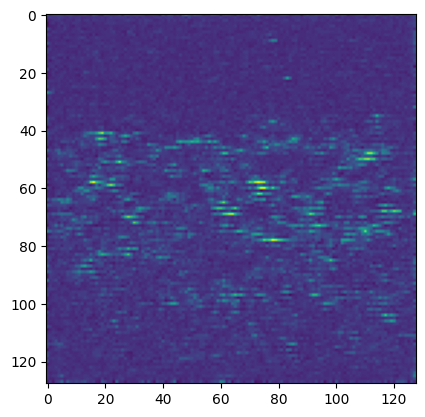

In [28]:
from torchvision.utils import save_image
from tqdm.auto import tqdm

num_epochs=21
progress_bar = tqdm(total=num_epochs, disable=False)
test_dir='./samples'
# !rm -rf {test_dir}
os.makedirs(test_dir, exist_ok=True)

# plt.imshow(images[0].permute(1, 2, 0).cpu().detach().numpy())
# plt.savefig(f"{test_dir}/input.png")

start_epoch_scaler = 6
start_epoch = num_epochs*start_epoch_scaler
final_epoch = num_epochs*(start_epoch_scaler+2)
for epoch in (range(start_epoch, final_epoch)):
    progress_bar.set_description(f"Epoch {epoch}")
    optimizer.zero_grad()
    running_loss = {"loss" : 0}
    for batch in tqdm(train_dataloader):
        images=batch['image'][:,:,50:50+256,400:400+256].to(device)
        text_embeds=batch['encoding'].to(device)
        text_masks=batch['mask'].to(device)
        for i in range(1,2):
            loss = imagen(images, 
                          text_embeds=text_embeds,
                           text_masks=text_masks,
                        #   cond_images=cond_images,
                        unet_number=i)
            # loss=forward_out["loss"]
            loss.backward()
            running_loss["loss"] += loss.item()
        optimizer.step()

    progress_bar.update(1)

    if (epoch-1) % 2 == 0:
        print(f'Epoch: {epoch}\t{running_loss}')
        train_unet_losses["base"].append(running_loss["loss"])
        
        progress_bar.set_postfix(**running_loss)

        with torch.no_grad():
            samples = imagen.sample(
                text_embeds=text_embeds,
                text_masks=text_masks,
                cond_scale=1.0,
                # cond_images=cond_images,
                stop_at_unet_number=1,
            )

        plt.imshow(samples[0].permute(1, 2, 0).cpu().detach().numpy())
        plt.savefig(f"{test_dir}/{epoch:04d}.png")
torch.save(imagen.state_dict(), f"./sdm_cond_{final_epoch}.pt")

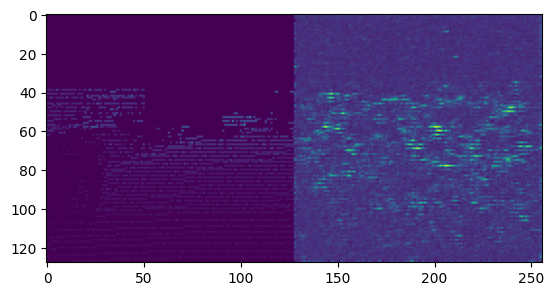

In [42]:
concatenated_img_and_denoised = torch.concatenate([transforms.Resize((128,128))(images[1]), samples[0]], dim=2)
plt.imshow(concatenated_img_and_denoised.permute(1, 2, 0).cpu().detach().numpy())